In [1]:
import pandas as pd
from src.train import *
from src.model import CNNLSTMModel
from src.dataset import *
from src.preprocess import *
from src.visualize import *
import torch

## Hyper-Parameter

In [2]:
performe_visualization = False

In [3]:
# some important parameters
pre_day = 5

feature_cols = [
    "metric.STATUS_AC_MOD_ADMISSION_TEMP.MEASURED",  # ambient temperature
    "metric.STATUS_INTERNAL_TEMP.MEASURED",          # internal temperature
    "metric.AC_VOLTAGE_AB.MEASURED",                 # AC voltage
    "metric.AC_VOLTAGE_BC.MEASURED",                 # AC voltage
    "metric.AC_VOLTAGE_CA.MEASURED",                 # AC voltage
    "metric.DC_VOLTAGE.MEASURED",                  # DC voltage
    "metric.AC_POWER.MEASURED",                     # AC power
]

exclude_periods = [
    [pd.Timestamp('2021-01-01'), pd.Timestamp('2021-12-23')], # data collection issue
    [pd.Timestamp('2023-02-23'), pd.Timestamp('2023-08-26')], # anomalies in the data
]

## Data Preprocessing
### Load Data

In [4]:
inverter_data = load_parquet_data('data/inverter_data')
failure_sessions = load_failure_sessions('data/failure_sessions_w_maintenance.csv', min_days=3)

Loaded 15 parquet files → 6126272 rows
Kept 61 sessions longer than 3 days


In [5]:
visualize_failure_timeline(failure_sessions)

In [6]:
if performe_visualization:
    # Visualize the raw data
    visualize_mean_values(inverter_data, failure_sessions, feature_cols, 'visualization', 'raw_data')

In [7]:
# remove unused columns
filtered_data = inverter_data[['event_local_time', 'device_name'] + feature_cols].copy()

### Anomoly Detection

In [8]:
if "metric.STATUS_AC_MOD_ADMISSION_TEMP.MEASURED" in filtered_data.columns:
    anomaly_ids = filtered_data["metric.STATUS_AC_MOD_ADMISSION_TEMP.MEASURED"]>=100
    filtered_data.loc[anomaly_ids, "metric.STATUS_AC_MOD_ADMISSION_TEMP.MEASURED"] = None
    print("Anomalies in STATUS_AC_MOD_ADMISSION_TEMP removed:", anomaly_ids.sum())

Anomalies in STATUS_AC_MOD_ADMISSION_TEMP removed: 244163


### Missing Value Imputation

In [9]:
imputed_df = missing_value_imputation(
    filtered_data, feature_cols, 
    time_col='event_local_time', 
    device_col='device_name', 
    short_gap_limit=0, 
    long_fill_value=0.0, 
    add_missing_mask=True
    )
extended_feature_cols = feature_cols+[col+'_missing' for col in feature_cols]

### Downsampling

In [10]:
downsampled_data = downsample_inverter_raw(imputed_df, drop_empty_bins=False)
downsampled_data.dropna(inplace=True) # NaN will be generated by downsampling, so we drop them

Downsampling 6126272 rows using following method: 
                                               Column Aggregation
0                       metric.AC_VOLTAGE_AB.MEASURED        mean
1                       metric.AC_VOLTAGE_BC.MEASURED        mean
2                       metric.AC_VOLTAGE_CA.MEASURED        mean
3                          metric.DC_VOLTAGE.MEASURED        mean
4                            metric.AC_POWER.MEASURED        mean
5               metric.AC_VOLTAGE_AB.MEASURED_missing        mean
6               metric.AC_VOLTAGE_BC.MEASURED_missing        mean
7               metric.AC_VOLTAGE_CA.MEASURED_missing        mean
8                  metric.DC_VOLTAGE.MEASURED_missing        mean
9                    metric.AC_POWER.MEASURED_missing        mean
10       metric.STATUS_AC_MOD_ADMISSION_TEMP.MEASURED         max
11               metric.STATUS_INTERNAL_TEMP.MEASURED         max
12  metric.STATUS_AC_MOD_ADMISSION_TEMP.MEASURED_m...        mean
13       metric.STATUS_IN

In [11]:
if performe_visualization:
    # Visualize the downsampled data
    visualize_mean_values(
        downsampled_data, 
        failure_sessions, 
        extended_feature_cols, 
        'visualization', 
        'downsampled_data',
        freq=None
    )

### Data Cleaning

In [12]:
print("failure_sessions shape:", failure_sessions.shape)
failure_sessions['event_local_time'] = failure_sessions['start_time']
filtered_sessions = exclude_periods_from_data(failure_sessions, exclude_periods)
filtered_sessions['event_local_time'] = filtered_sessions['end_time']
filtered_sessions = exclude_periods_from_data(filtered_sessions, exclude_periods)
print("failure_sessions shape:", filtered_sessions .shape)

failure_sessions shape: (61, 6)
Excluded 2 periods, remaining data size: 47
Excluded 2 periods, remaining data size: 47
failure_sessions shape: (47, 7)


In [13]:
visualize_failure_timeline(filtered_sessions)

In [14]:
print("inverter_data shape:", downsampled_data.shape)
downsampled_data = exclude_periods_from_data(downsampled_data, exclude_periods)
print("Excluded data shape:", downsampled_data.shape)

inverter_data shape: (1021056, 16)
Excluded 2 periods, remaining data size: 862112
Excluded data shape: (862112, 16)


### Data Labeling

In [15]:
downsampled_data = prepare_dataset(downsampled_data, failure_sessions, pre_days=pre_day)

Total pre-failure rows: 5584
Total rows: 837811


### Feature Engineering

In [16]:
# month_of_year 範圍 1~12
downsampled_data['month_sin'] = np.sin(2 * np.pi * downsampled_data['event_local_time'].dt.month / 12)
downsampled_data['month_cos'] = np.cos(2 * np.pi * downsampled_data['event_local_time'].dt.month / 12)

# 如果還有 hour_of_day (0~23) 也可以同理轉
downsampled_data['hour_sin'] = np.sin(2 * np.pi * downsampled_data['event_local_time'].dt.hour / 24)
downsampled_data['hour_cos'] = np.cos(2 * np.pi * downsampled_data['event_local_time'].dt.hour / 24)

extended_feature_cols += ['hour_sin', 'hour_cos', 'month_sin', 'month_cos']

In [17]:
if performe_visualization:
    visualize_mean_values(downsampled_data, failure_sessions, extended_feature_cols+['label'], 
                                title='processed_data', freq=None)

### Split Dataset

In [18]:
split_time = [pd.Timestamp('2024-06-30'), pd.Timestamp('2025-01-01')]


train_df = downsampled_data[downsampled_data['event_local_time'] <= split_time[0]].copy()
val_df = downsampled_data[(downsampled_data['event_local_time'] > split_time[0]) & (downsampled_data['event_local_time'] <= split_time[1])].copy()
test_df = downsampled_data[downsampled_data['event_local_time'] > split_time[1]].copy()

In [19]:
print('train set period:', train_df['event_local_time'].min(), train_df['event_local_time'].max())
print('validation set period:', val_df['event_local_time'].min(), val_df['event_local_time'].max())
print('test set period:', test_df['event_local_time'].min(), test_df['event_local_time'].max())

train set period: 2021-12-24 00:00:00 2024-06-30 00:00:00
validation set period: 2024-06-30 00:30:00 2025-01-01 00:00:00
test set period: 2025-01-01 00:30:00 2025-07-23 23:30:00


In [20]:
extended_feature_cols

['metric.STATUS_AC_MOD_ADMISSION_TEMP.MEASURED',
 'metric.STATUS_INTERNAL_TEMP.MEASURED',
 'metric.AC_VOLTAGE_AB.MEASURED',
 'metric.AC_VOLTAGE_BC.MEASURED',
 'metric.AC_VOLTAGE_CA.MEASURED',
 'metric.DC_VOLTAGE.MEASURED',
 'metric.AC_POWER.MEASURED',
 'metric.STATUS_AC_MOD_ADMISSION_TEMP.MEASURED_missing',
 'metric.STATUS_INTERNAL_TEMP.MEASURED_missing',
 'metric.AC_VOLTAGE_AB.MEASURED_missing',
 'metric.AC_VOLTAGE_BC.MEASURED_missing',
 'metric.AC_VOLTAGE_CA.MEASURED_missing',
 'metric.DC_VOLTAGE.MEASURED_missing',
 'metric.AC_POWER.MEASURED_missing',
 'hour_sin',
 'hour_cos',
 'month_sin',
 'month_cos']

### Standardization

In [21]:
from sklearn.preprocessing import StandardScaler
feature_to_standardize = feature_cols
scaler = StandardScaler()
train_df[feature_to_standardize] = scaler.fit_transform(train_df[feature_to_standardize])
val_df[feature_to_standardize] = scaler.transform(val_df[feature_to_standardize])
test_df[feature_to_standardize] = scaler.transform(test_df[feature_to_standardize])

In [22]:
if performe_visualization:
    visualize_mean_values(train_df, failure_sessions, extended_feature_cols+['label'], 
                                 'visualization', 'train_data', freq=None)
    visualize_mean_values(val_df, failure_sessions, extended_feature_cols+['label'], 
                                 'visualization', 'val_data', freq=None)
    visualize_mean_values(test_df, failure_sessions, extended_feature_cols+['label'],
                                    'visualization', 'test_data', freq=None)

### Create Dataset/Data Loader

In [23]:
from torch.utils.data import DataLoader
window_size = 2*24*7 # 30 minutes*2*24*7 = 7 days
normal_stride = 2*6 # 30 minutes*2*6 = 6 hours
positive_sample_stride = 2

positive_ds = PositiveInverterTimeSeriesDataset.from_dataframe(train_df, extended_feature_cols, window_size=window_size, stride=positive_sample_stride)
negative_ds = NegativeInverterTimeSeriesDataset.from_dataframe(train_df, extended_feature_cols, window_size=window_size, stride=normal_stride)

train_ds = combine_dataset([positive_ds, negative_ds])
val_ds   = InverterTimeSeriesDataset.from_dataframe(val_df,   extended_feature_cols, window_size=window_size, stride=normal_stride)
test_ds  = InverterTimeSeriesDataset.from_dataframe(test_df,  extended_feature_cols, window_size=window_size, stride=normal_stride)

Processing devices: 100%|██████████| 16/16 [00:00<00:00, 74.78it/s]


In [24]:
# information of datasets
print("train_ds.X.shape:", train_ds.X.shape)
print("val_ds.X.shape:", val_ds.X.shape)
print("test_ds.X.shape:", test_ds.X.shape)

train_ds.X.shape: torch.Size([44504, 336, 18])
val_ds.X.shape: torch.Size([11270, 336, 18])
test_ds.X.shape: torch.Size([10979, 336, 18])


In [25]:
pd.value_counts(train_ds.y.numpy()), pd.value_counts(val_ds.y.numpy()), pd.value_counts(test_ds.y.numpy())

(0.0    42584
 1.0     1920
 dtype: int64,
 0.0    11210
 1.0       60
 dtype: int64,
 0.0    10919
 1.0       60
 dtype: int64)

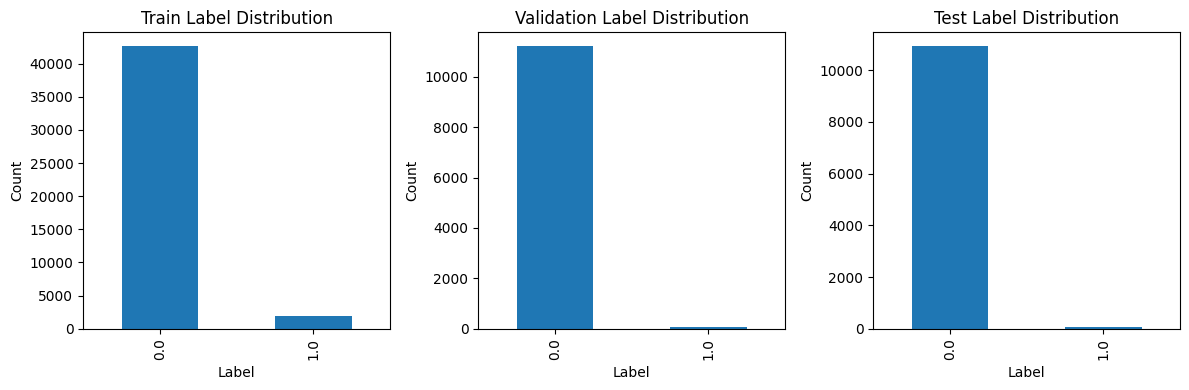

In [26]:
import matplotlib.pyplot as plt

# 計算各資料集的標籤分佈
train_counts = pd.Series(train_ds.y.numpy()).value_counts()
val_counts   = pd.Series(val_ds.y.numpy()).value_counts()
test_counts  = pd.Series(test_ds.y.numpy()).value_counts()

# 畫圖
fig, axes = plt.subplots(1, 3, figsize=(12, 4))

for ax, counts, title in zip(
    axes,
    [train_counts, val_counts, test_counts],
    ["Train", "Validation", "Test"]
):
    counts.plot(kind='bar', ax=ax)
    ax.set_title(f"{title} Label Distribution")
    ax.set_xlabel("Label")
    ax.set_ylabel("Count")

plt.tight_layout()
plt.show()


In [27]:
import numpy as np
import torch
from torch.utils.data import DataLoader, WeightedRandomSampler

# 取出標籤（假設 train_ds.y 是 0/1 的 torch.tensor）
y = train_ds.y.cpu().numpy()
assert set(np.unique(y)).issubset({0,1}), "train_ds 應只有 0/1 標籤"

num_pos = int((y == 1).sum())
num_neg = int((y == 0).sum())
p_target = 0.15 # 你可以之後調 0.2~0.35

# 權重：讓期望抽樣比例 ≈ p_target
w_pos = p_target / max(num_pos, 1)
w_neg = (1.0 - p_target) / max(num_neg, 1)
sample_weights = np.where(y == 1, w_pos, w_neg).astype(np.float64)
sample_weights = torch.from_numpy(sample_weights)

balanced_sampler = WeightedRandomSampler(
    weights=sample_weights,
    num_samples=len(sample_weights),  # 每個 epoch 跑滿步數
    replacement=True
)

In [28]:
train_loader = DataLoader(
    train_ds,
    batch_size=512,         # 或你的 GPU 極限
    #sampler=balanced_sampler,
    shuffle=True,  # 如果不使用 sampler，則需要 shuffle
    num_workers=8,
    pin_memory=True,
    drop_last=True
)

val_loader = DataLoader(val_ds, batch_size=1024, shuffle=False, num_workers=8, pin_memory=True)
test_loader = DataLoader(test_ds, batch_size=1024, shuffle=False, num_workers=8, pin_memory=True)

## Train Model

In [29]:
import torch.nn as nn
import torch.nn.functional as F

class FocalLoss(nn.Module):
    def __init__(self, alpha=0.75, gamma=2.0, reduction='mean'):
        super().__init__()
        self.alpha = alpha
        self.gamma = gamma
        self.reduction = reduction
    def forward(self, logits, targets):
        # logits: (B,1) raw; targets: (B,1) {0,1}
        bce = F.binary_cross_entropy_with_logits(logits, targets, reduction='none')
        p = torch.sigmoid(logits).clamp(1e-6, 1-1e-6)
        pt = p*targets + (1-p)*(1-targets)
        w = self.alpha*targets + (1-self.alpha)*(1-targets)
        loss = w * (1-pt).pow(self.gamma) * bce
        return loss.mean() if self.reduction=='mean' else loss.sum()

criterion = FocalLoss(alpha=0.75, gamma=2.0)
# 如果改用 BCE：
# criterion = nn.BCEWithLogitsLoss(pos_weight=torch.tensor([1.2], device=device))


In [30]:
model = CNNLSTMModel(
    num_features=len(extended_feature_cols),
    cnn_out_channels=32,   # 32 → 64
    lstm_hidden_size=64,  # 64 → 128
    lstm_layers=2,         # 1 → 2
    dropout=0.5
)

In [31]:
import math
from torch.optim import AdamW

optimizer = AdamW(model.parameters(), lr=3e-4, weight_decay=1e-4)

steps_per_epoch = len(train_loader)
max_epochs = 30
total_steps = steps_per_epoch * max_epochs
warmup_steps = max(1, int(total_steps * 0.05))

def lr_lambda(current_step):
    if current_step < warmup_steps:
        return float(current_step) / float(max(1, warmup_steps))
    progress = (current_step - warmup_steps) / float(max(1, total_steps - warmup_steps))
    cosine = 0.5 * (1.0 + math.cos(math.pi * progress))
    return 0.1 + 0.9 * cosine  # 下界 0.1×

scheduler = torch.optim.lr_scheduler.LambdaLR(optimizer, lr_lambda)


In [32]:

log = train_loop(
    model, train_loader, val_loader, 
    log_interval=25, 
    num_epochs=30, 
    optimizer=optimizer, 
    criterion=criterion,
    scheduler=scheduler,
    save_interval=1,
    #save_path='model/0814_0457'
)

Model moved to cuda
[Epoch 1/30] Step 0/86 - Loss: 0.0392
[Epoch 1/30] Step 25/86 - Loss: 0.0404
[Epoch 1/30] Step 50/86 - Loss: 0.0397
[Epoch 1/30] Step 75/86 - Loss: 0.0373
🔁 Epoch 1 finished. Avg Train Loss: 0.0387


Testing: 100%|██████████| 12/12 [00:07<00:00,  1.52it/s]


✅ avg_loss: 0.0278 | AUC-PR: 0.0101 | baseline: 0.0053 | uplift: 1.90x | P@50:0.000 R@50:0.000 | P@100:0.000 R@100:0.000 | P@200:0.000 R@200:0.000
Best model saved at epoch 1 with AUC-PR 0.0101
[Epoch 2/30] Step 0/86 - Loss: 0.0348
[Epoch 2/30] Step 25/86 - Loss: 0.0223
[Epoch 2/30] Step 50/86 - Loss: 0.0287
[Epoch 2/30] Step 75/86 - Loss: 0.0226
🔁 Epoch 2 finished. Avg Train Loss: 0.0277


Testing: 100%|██████████| 12/12 [00:07<00:00,  1.61it/s]


✅ avg_loss: 0.0121 | AUC-PR: 0.0312 | baseline: 0.0053 | uplift: 5.86x | P@50:0.040 R@50:0.033 | P@100:0.040 R@100:0.067 | P@200:0.030 R@200:0.100
Best model saved at epoch 2 with AUC-PR 0.0312
[Epoch 3/30] Step 0/86 - Loss: 0.0283
[Epoch 3/30] Step 25/86 - Loss: 0.0209
[Epoch 3/30] Step 50/86 - Loss: 0.0208
[Epoch 3/30] Step 75/86 - Loss: 0.0236
🔁 Epoch 3 finished. Avg Train Loss: 0.0248


Testing: 100%|██████████| 12/12 [00:07<00:00,  1.62it/s]


✅ avg_loss: 0.0143 | AUC-PR: 0.0501 | baseline: 0.0053 | uplift: 9.42x | P@50:0.060 R@50:0.050 | P@100:0.090 R@100:0.150 | P@200:0.085 R@200:0.283
Best model saved at epoch 3 with AUC-PR 0.0501
[Epoch 4/30] Step 0/86 - Loss: 0.0268
[Epoch 4/30] Step 25/86 - Loss: 0.0250
[Epoch 4/30] Step 50/86 - Loss: 0.0186
[Epoch 4/30] Step 75/86 - Loss: 0.0179
🔁 Epoch 4 finished. Avg Train Loss: 0.0219


Testing: 100%|██████████| 12/12 [00:07<00:00,  1.67it/s]


✅ avg_loss: 0.0110 | AUC-PR: 0.0506 | baseline: 0.0053 | uplift: 9.50x | P@50:0.020 R@50:0.017 | P@100:0.050 R@100:0.083 | P@200:0.075 R@200:0.250
Best model saved at epoch 4 with AUC-PR 0.0506
[Epoch 5/30] Step 0/86 - Loss: 0.0168
[Epoch 5/30] Step 25/86 - Loss: 0.0282
[Epoch 5/30] Step 50/86 - Loss: 0.0184
[Epoch 5/30] Step 75/86 - Loss: 0.0208
🔁 Epoch 5 finished. Avg Train Loss: 0.0213


Testing: 100%|██████████| 12/12 [00:07<00:00,  1.63it/s]


✅ avg_loss: 0.0127 | AUC-PR: 0.0472 | baseline: 0.0053 | uplift: 8.86x | P@50:0.040 R@50:0.033 | P@100:0.070 R@100:0.117 | P@200:0.090 R@200:0.300
[Epoch 6/30] Step 0/86 - Loss: 0.0227
[Epoch 6/30] Step 25/86 - Loss: 0.0174
[Epoch 6/30] Step 50/86 - Loss: 0.0224
[Epoch 6/30] Step 75/86 - Loss: 0.0225
🔁 Epoch 6 finished. Avg Train Loss: 0.0203


Testing: 100%|██████████| 12/12 [00:07<00:00,  1.55it/s]


✅ avg_loss: 0.0116 | AUC-PR: 0.0337 | baseline: 0.0053 | uplift: 6.33x | P@50:0.000 R@50:0.000 | P@100:0.010 R@100:0.017 | P@200:0.050 R@200:0.167
[Epoch 7/30] Step 0/86 - Loss: 0.0197
[Epoch 7/30] Step 25/86 - Loss: 0.0151
[Epoch 7/30] Step 50/86 - Loss: 0.0201
[Epoch 7/30] Step 75/86 - Loss: 0.0241
🔁 Epoch 7 finished. Avg Train Loss: 0.0204


Testing: 100%|██████████| 12/12 [00:07<00:00,  1.51it/s]


✅ avg_loss: 0.0139 | AUC-PR: 0.0336 | baseline: 0.0053 | uplift: 6.31x | P@50:0.020 R@50:0.017 | P@100:0.020 R@100:0.033 | P@200:0.040 R@200:0.133
[Epoch 8/30] Step 0/86 - Loss: 0.0180
[Epoch 8/30] Step 25/86 - Loss: 0.0203
[Epoch 8/30] Step 50/86 - Loss: 0.0170
[Epoch 8/30] Step 75/86 - Loss: 0.0185
🔁 Epoch 8 finished. Avg Train Loss: 0.0194


Testing: 100%|██████████| 12/12 [00:07<00:00,  1.59it/s]


✅ avg_loss: 0.0149 | AUC-PR: 0.0350 | baseline: 0.0053 | uplift: 6.57x | P@50:0.020 R@50:0.017 | P@100:0.020 R@100:0.033 | P@200:0.050 R@200:0.167
[Epoch 9/30] Step 0/86 - Loss: 0.0220
[Epoch 9/30] Step 25/86 - Loss: 0.0209
[Epoch 9/30] Step 50/86 - Loss: 0.0180
[Epoch 9/30] Step 75/86 - Loss: 0.0255
🔁 Epoch 9 finished. Avg Train Loss: 0.0190


Testing: 100%|██████████| 12/12 [00:07<00:00,  1.61it/s]


✅ avg_loss: 0.0183 | AUC-PR: 0.0316 | baseline: 0.0053 | uplift: 5.93x | P@50:0.020 R@50:0.017 | P@100:0.020 R@100:0.033 | P@200:0.020 R@200:0.067
[Epoch 10/30] Step 0/86 - Loss: 0.0148
[Epoch 10/30] Step 25/86 - Loss: 0.0199
[Epoch 10/30] Step 50/86 - Loss: 0.0185
[Epoch 10/30] Step 75/86 - Loss: 0.0193
🔁 Epoch 10 finished. Avg Train Loss: 0.0190


Testing: 100%|██████████| 12/12 [00:07<00:00,  1.67it/s]


✅ avg_loss: 0.0118 | AUC-PR: 0.0361 | baseline: 0.0053 | uplift: 6.78x | P@50:0.020 R@50:0.017 | P@100:0.020 R@100:0.033 | P@200:0.020 R@200:0.067
[Epoch 11/30] Step 0/86 - Loss: 0.0196
[Epoch 11/30] Step 25/86 - Loss: 0.0157
[Epoch 11/30] Step 50/86 - Loss: 0.0168
[Epoch 11/30] Step 75/86 - Loss: 0.0174
🔁 Epoch 11 finished. Avg Train Loss: 0.0188


Testing: 100%|██████████| 12/12 [00:07<00:00,  1.51it/s]


✅ avg_loss: 0.0124 | AUC-PR: 0.0344 | baseline: 0.0053 | uplift: 6.45x | P@50:0.020 R@50:0.017 | P@100:0.020 R@100:0.033 | P@200:0.015 R@200:0.050
[Epoch 12/30] Step 0/86 - Loss: 0.0200
[Epoch 12/30] Step 25/86 - Loss: 0.0177
[Epoch 12/30] Step 50/86 - Loss: 0.0171
[Epoch 12/30] Step 75/86 - Loss: 0.0205
🔁 Epoch 12 finished. Avg Train Loss: 0.0179


Testing: 100%|██████████| 12/12 [00:07<00:00,  1.63it/s]


✅ avg_loss: 0.0123 | AUC-PR: 0.0323 | baseline: 0.0053 | uplift: 6.08x | P@50:0.000 R@50:0.000 | P@100:0.020 R@100:0.033 | P@200:0.015 R@200:0.050
[Epoch 13/30] Step 0/86 - Loss: 0.0117
[Epoch 13/30] Step 25/86 - Loss: 0.0135
[Epoch 13/30] Step 50/86 - Loss: 0.0241
[Epoch 13/30] Step 75/86 - Loss: 0.0235
🔁 Epoch 13 finished. Avg Train Loss: 0.0180


Testing: 100%|██████████| 12/12 [00:08<00:00,  1.50it/s]


✅ avg_loss: 0.0110 | AUC-PR: 0.0304 | baseline: 0.0053 | uplift: 5.71x | P@50:0.000 R@50:0.000 | P@100:0.020 R@100:0.033 | P@200:0.020 R@200:0.067
[Epoch 14/30] Step 0/86 - Loss: 0.0187
[Epoch 14/30] Step 25/86 - Loss: 0.0149
[Epoch 14/30] Step 50/86 - Loss: 0.0144
[Epoch 14/30] Step 75/86 - Loss: 0.0147
🔁 Epoch 14 finished. Avg Train Loss: 0.0171


Testing: 100%|██████████| 12/12 [00:08<00:00,  1.50it/s]

✅ avg_loss: 0.0142 | AUC-PR: 0.0297 | baseline: 0.0053 | uplift: 5.58x | P@50:0.000 R@50:0.000 | P@100:0.020 R@100:0.033 | P@200:0.015 R@200:0.050


[Epoch 15/30] Step 0/86 - Loss: 0.0167
[Epoch 15/30] Step 25/86 - Loss: 0.0144
[Epoch 15/30] Step 50/86 - Loss: 0.0173
[Epoch 15/30] Step 75/86 - Loss: 0.0154
🔁 Epoch 15 finished. Avg Train Loss: 0.0165


Testing: 100%|██████████| 12/12 [00:07<00:00,  1.58it/s]


✅ avg_loss: 0.0132 | AUC-PR: 0.0304 | baseline: 0.0053 | uplift: 5.71x | P@50:0.000 R@50:0.000 | P@100:0.020 R@100:0.033 | P@200:0.015 R@200:0.050
[Epoch 16/30] Step 0/86 - Loss: 0.0197
[Epoch 16/30] Step 25/86 - Loss: 0.0152
[Epoch 16/30] Step 50/86 - Loss: 0.0233
[Epoch 16/30] Step 75/86 - Loss: 0.0163
🔁 Epoch 16 finished. Avg Train Loss: 0.0163


Testing: 100%|██████████| 12/12 [00:07<00:00,  1.59it/s]


✅ avg_loss: 0.0160 | AUC-PR: 0.0237 | baseline: 0.0053 | uplift: 4.44x | P@50:0.000 R@50:0.000 | P@100:0.010 R@100:0.017 | P@200:0.015 R@200:0.050
[Epoch 17/30] Step 0/86 - Loss: 0.0154
[Epoch 17/30] Step 25/86 - Loss: 0.0157
[Epoch 17/30] Step 50/86 - Loss: 0.0091
[Epoch 17/30] Step 75/86 - Loss: 0.0172
🔁 Epoch 17 finished. Avg Train Loss: 0.0166


Testing: 100%|██████████| 12/12 [00:07<00:00,  1.62it/s]


✅ avg_loss: 0.0170 | AUC-PR: 0.0241 | baseline: 0.0053 | uplift: 4.53x | P@50:0.000 R@50:0.000 | P@100:0.010 R@100:0.017 | P@200:0.015 R@200:0.050
[Epoch 18/30] Step 0/86 - Loss: 0.0142
[Epoch 18/30] Step 25/86 - Loss: 0.0194
[Epoch 18/30] Step 50/86 - Loss: 0.0210
[Epoch 18/30] Step 75/86 - Loss: 0.0128
🔁 Epoch 18 finished. Avg Train Loss: 0.0159


Testing: 100%|██████████| 12/12 [00:07<00:00,  1.60it/s]


✅ avg_loss: 0.0125 | AUC-PR: 0.0275 | baseline: 0.0053 | uplift: 5.17x | P@50:0.000 R@50:0.000 | P@100:0.020 R@100:0.033 | P@200:0.015 R@200:0.050
[Epoch 19/30] Step 0/86 - Loss: 0.0155
[Epoch 19/30] Step 25/86 - Loss: 0.0158
[Epoch 19/30] Step 50/86 - Loss: 0.0157
[Epoch 19/30] Step 75/86 - Loss: 0.0214
🔁 Epoch 19 finished. Avg Train Loss: 0.0153


Testing: 100%|██████████| 12/12 [00:07<00:00,  1.57it/s]


✅ avg_loss: 0.0157 | AUC-PR: 0.0237 | baseline: 0.0053 | uplift: 4.46x | P@50:0.000 R@50:0.000 | P@100:0.000 R@100:0.000 | P@200:0.015 R@200:0.050
[Epoch 20/30] Step 0/86 - Loss: 0.0157
[Epoch 20/30] Step 25/86 - Loss: 0.0125
[Epoch 20/30] Step 50/86 - Loss: 0.0117
[Epoch 20/30] Step 75/86 - Loss: 0.0158
🔁 Epoch 20 finished. Avg Train Loss: 0.0149


Testing: 100%|██████████| 12/12 [00:07<00:00,  1.57it/s]


✅ avg_loss: 0.0146 | AUC-PR: 0.0266 | baseline: 0.0053 | uplift: 5.00x | P@50:0.000 R@50:0.000 | P@100:0.010 R@100:0.017 | P@200:0.015 R@200:0.050
[Epoch 21/30] Step 0/86 - Loss: 0.0143
[Epoch 21/30] Step 25/86 - Loss: 0.0191
[Epoch 21/30] Step 50/86 - Loss: 0.0139
[Epoch 21/30] Step 75/86 - Loss: 0.0126
🔁 Epoch 21 finished. Avg Train Loss: 0.0148


Testing: 100%|██████████| 12/12 [00:07<00:00,  1.59it/s]


✅ avg_loss: 0.0143 | AUC-PR: 0.0248 | baseline: 0.0053 | uplift: 4.67x | P@50:0.000 R@50:0.000 | P@100:0.010 R@100:0.017 | P@200:0.015 R@200:0.050
[Epoch 22/30] Step 0/86 - Loss: 0.0171
[Epoch 22/30] Step 25/86 - Loss: 0.0092
[Epoch 22/30] Step 50/86 - Loss: 0.0155
[Epoch 22/30] Step 75/86 - Loss: 0.0096
🔁 Epoch 22 finished. Avg Train Loss: 0.0146


Testing:   0%|          | 0/12 [00:00<?, ?it/s]


KeyboardInterrupt: 

In [ ]:
#log = pd.read_csv('model/0813_1935/training_log.csv')

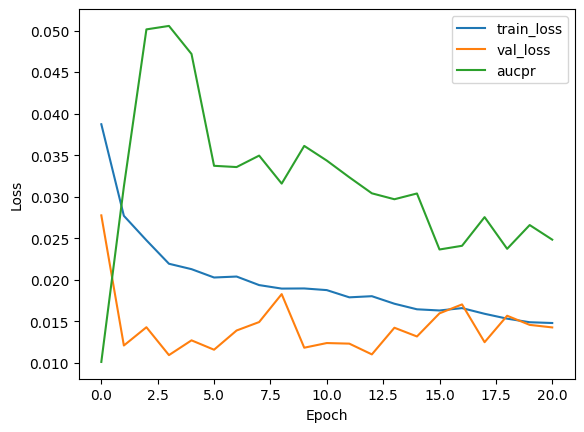

In [54]:
import matplotlib.pyplot as plt
log = pd.read_csv('model/0814_1355/training_log.csv')
plt.plot(log['train_loss'], label='train_loss')
plt.plot(log['val_loss'], label='val_loss')
plt.plot(log['aucpr'], label='aucpr')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

### Model Evaluation

In [72]:
model.load_state_dict(torch.load(r'model\0814_1355\epoch_5.pth', weights_only=True))

<All keys matched successfully>

In [73]:
# 評估 train 分佈：不用 sampler、不shuffle
train_loader_eval = DataLoader(
    train_ds, batch_size=1024, shuffle=False, num_workers=8, pin_memory=True
)


In [74]:
train_trues, train_outputs, train_loss= test_loop(model, train_loader_eval, criterion=criterion)


Testing: 100%|██████████| 44/44 [00:08<00:00,  5.11it/s]


In [75]:
def plot_outputs_distribution(outputs, title):
    plt.hist(outputs, bins=50, range=(0, 1))
    plt.xlabel("Output Value")
    plt.ylabel("Frequency")
    plt.title(title)
    plt.show()


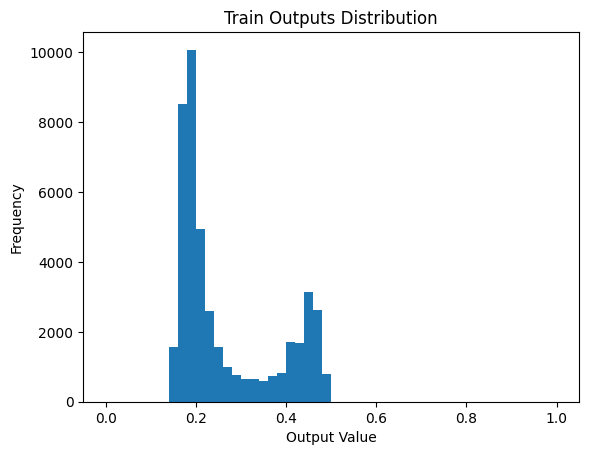

In [76]:
plot_outputs_distribution(train_outputs, "Train Outputs Distribution")

Performance on Training Set:
Train Loss: 0.019591238995252006
              precision    recall  f1-score   support

      Normal       0.99      0.76      0.86     42584
     Failure       0.14      0.83      0.23      1920

    accuracy                           0.76     44504
   macro avg       0.56      0.80      0.55     44504
weighted avg       0.95      0.76      0.83     44504

[[32364 10220]
 [  324  1596]]
ROC AUC: 0.8484


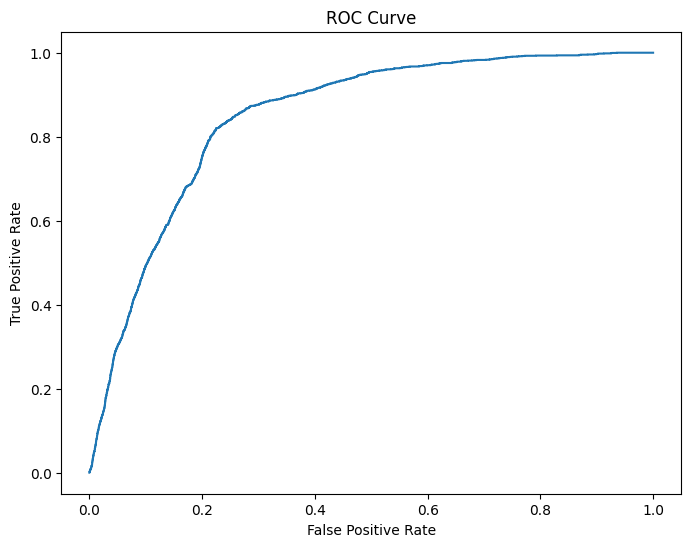

In [77]:
train_predictions = (train_outputs > 0.35).astype(int)

print("Performance on Training Set:")
print("Train Loss:", train_loss)

generate_report(train_trues, train_predictions, train_outputs)

In [78]:
from sklearn.linear_model import LogisticRegression
import numpy as np

# === 1. 取得 validation logits & labels ===
# 假設你有個函數可以批量推論並返回 logits (未經 sigmoid)
def get_logits_and_labels(model, dataloader, device='cuda'):
    model.eval()
    all_logits, all_labels = [], []
    with torch.no_grad():
        for X, y in dataloader:
            X, y = X.to(device), y.to(device)
            logits = model(X)  # shape: (batch, 1)
            all_logits.append(logits.cpu().numpy().ravel())
            all_labels.append(y.cpu().numpy().ravel())
    return np.concatenate(all_logits), np.concatenate(all_labels)

val_logits, val_labels = get_logits_and_labels(model, val_loader)
test_logits, test_labels = get_logits_and_labels(model, test_loader)

# === 2. Platt scaling (logistic regression) ===
platt = LogisticRegression(solver='lbfgs')
platt.fit(val_logits.reshape(-1, 1), val_labels)

# === 3. 校準分數 ===
val_probs_calibrated = platt.predict_proba(val_logits.reshape(-1, 1))[:, 1]
test_probs_calibrated = platt.predict_proba(test_logits.reshape(-1, 1))[:, 1]

# === 4. 在 val 上找最佳門檻 ===
from sklearn.metrics import precision_recall_curve

precision, recall, thresholds = precision_recall_curve(val_labels, val_probs_calibrated)

# 例如：找 F1 分數最高的門檻
target_recall = 0.8
best_idx = next(i for i,r in enumerate(recall) if r < target_recall) - 1
best_threshold = thresholds[best_idx]
print(f"Threshold for recall ≥ {target_recall}: {best_threshold:.4f}, Precision={precision[best_idx]:.3f}")

print(f"Best threshold (F1): {best_threshold:.4f}")
print(f"Precision: {precision[best_idx]:.4f}, Recall: {recall[best_idx]:.4f}")

# === 5. 在 test set 上套用門檻 ===
test_preds = (test_probs_calibrated >= best_threshold).astype(int)

from sklearn.metrics import classification_report, roc_auc_score
print(classification_report(test_labels, test_preds, digits=4))
print("Confusion Matrix:")
print(confusion_matrix(test_labels, test_preds))
print("ROC AUC:", roc_auc_score(test_labels, test_probs_calibrated))



Threshold for recall ≥ 0.8: 0.0177, Precision=0.027
Best threshold (F1): 0.0177
Precision: 0.0273, Recall: 0.8000
              precision    recall  f1-score   support

         0.0     0.9941    0.9316    0.9618     10919
         1.0     0.0000    0.0000    0.0000        60

    accuracy                         0.9265     10979
   macro avg     0.4971    0.4658    0.4809     10979
weighted avg     0.9887    0.9265    0.9566     10979

Confusion Matrix:
[[10172   747]
 [   60     0]]
ROC AUC: 0.5937753762554568


In [79]:
print(confusion_matrix(test_labels, test_preds))

[[10172   747]
 [   60     0]]


In [80]:
val_trues, val_outputs, val_loss = test_loop(model, val_loader, device='cuda', criterion=criterion)

Testing: 100%|██████████| 12/12 [00:08<00:00,  1.49it/s]


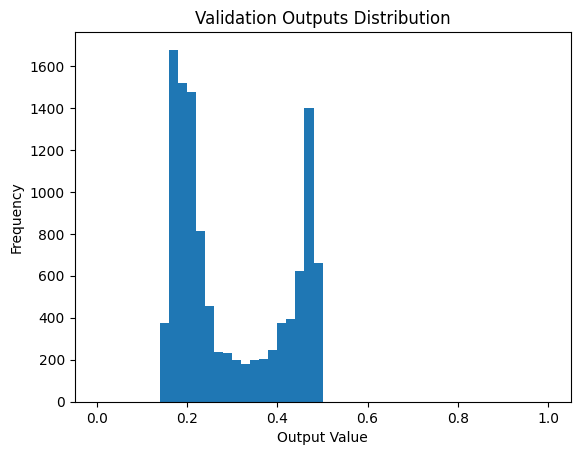

In [81]:
plot_outputs_distribution(val_outputs, "Validation Outputs Distribution")


In [82]:
from sklearn.metrics import precision_recall_curve
prec, rec, thresholds = precision_recall_curve(val_trues, val_outputs, pos_label=1)

target_recall = 0.6
idx = next(i for i,r in enumerate(rec) if r < target_recall) - 1
best_threshold = thresholds[idx]
print(f"Threshold for recall ≥ {target_recall}: {best_threshold:.4f}, Precision={prec[idx]:.3f}")


Threshold for recall ≥ 0.6: 0.4754, Precision=0.029


Performance on Validation Set:
              precision    recall  f1-score   support

      Normal       1.00      0.89      0.94     11210
     Failure       0.03      0.60      0.06        60

    accuracy                           0.89     11270
   macro avg       0.51      0.75      0.50     11270
weighted avg       0.99      0.89      0.94     11270

[[10021  1189]
 [   24    36]]
ROC AUC: 0.9062


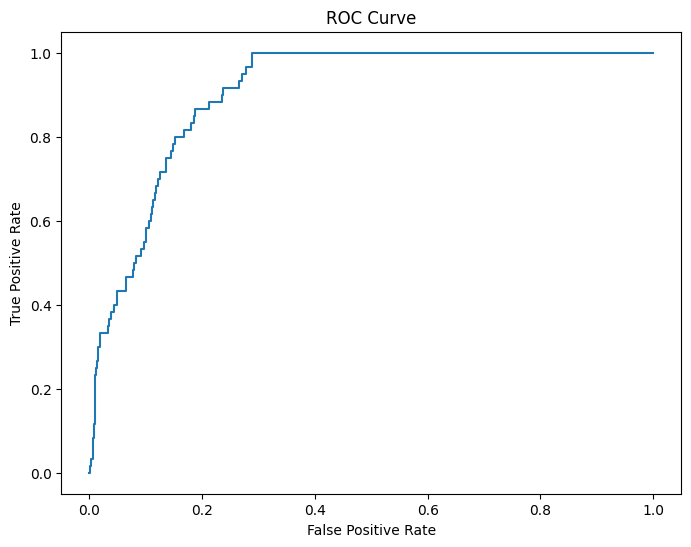

In [83]:
predictions = (val_outputs >= best_threshold).astype(int)
print("Performance on Validation Set:")
generate_report(val_trues, predictions, val_outputs)

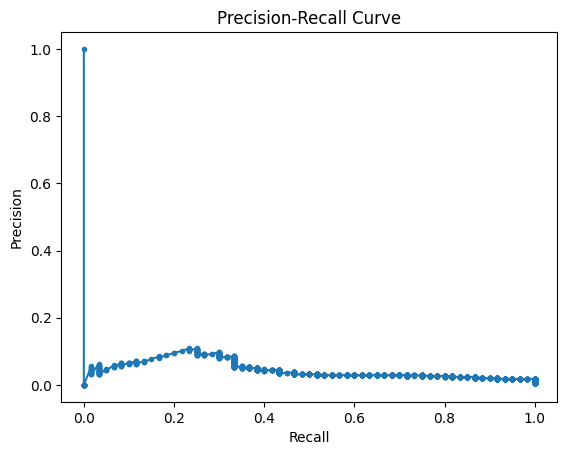

In [84]:
from sklearn.metrics import precision_recall_curve
precision, recall, thresholds = precision_recall_curve(val_trues, val_outputs)
plt.plot(recall, precision, marker='.')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.show()

In [85]:
test_trues, test_outputs, test_loss = test_loop(model, test_loader, device='cuda', criterion=criterion)

Testing: 100%|██████████| 11/11 [00:07<00:00,  1.47it/s]


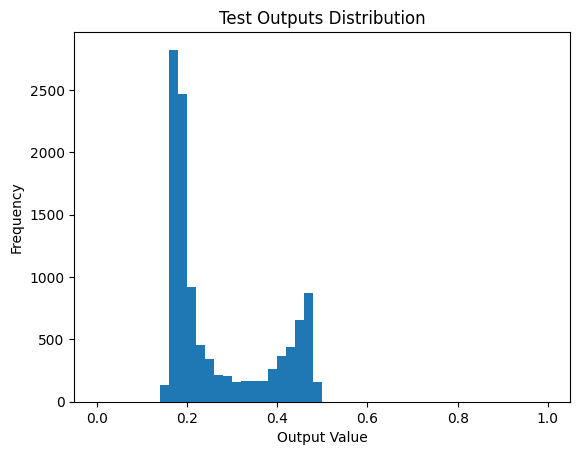

In [86]:
plot_outputs_distribution(test_outputs, "Test Outputs Distribution")

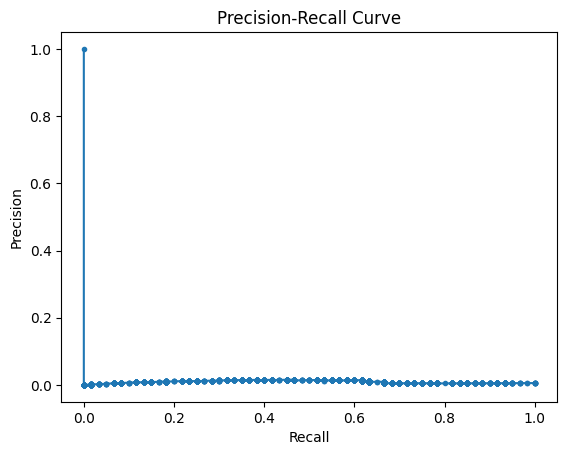

In [87]:
from sklearn.metrics import precision_recall_curve
precision, recall, thresholds = precision_recall_curve(test_trues, test_outputs)
plt.plot(recall, precision, marker='.')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.show()

Performance on Test Set:
              precision    recall  f1-score   support

      Normal       0.99      0.96      0.97     10919
     Failure       0.00      0.00      0.00        60

    accuracy                           0.95     10979
   macro avg       0.50      0.48      0.49     10979
weighted avg       0.99      0.95      0.97     10979

[[10440   479]
 [   60     0]]
ROC AUC: 0.5938


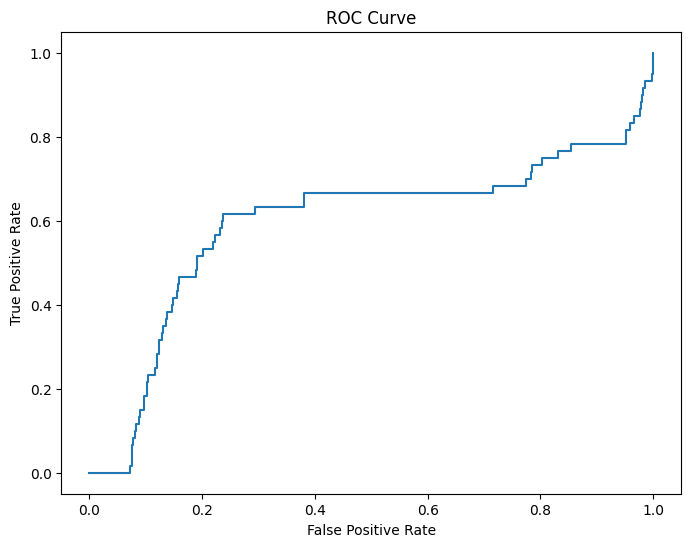

In [88]:
predictions = (test_outputs >= best_threshold).astype(int)
print("Performance on Test Set:")
generate_report(test_trues, predictions, test_outputs)